In [12]:
### Imports and Auxiliary Functions

import numpy as np
from math import pi
import matplotlib.pyplot as plt

In [13]:
### Auxiliary Functions for Number System Manipulations

def toBinary(x, bits):
    num = []
    while x > 1:
        rem = x % 2
        num.append(rem)
        x = int(x / 2)
    num.append(x)
    num = num[::-1]
    if(bits > len(num)):
        for i in range(bits - len(num)):
            num.insert(0, 0)
    return num

def toDecimal(x):
    x = np.array(x)
    x = x[::-1]
    n = np.size(x)
    value = np.sum(np.power(2, np.arange(n)) * x)
    return(value)

def bitreverser(x):
    x = np.array(x)
    N = np.size(x)
    indexes = np.arange(N)
    for i in range(N):
        indexes[i] = toDecimal(toBinary(indexes[i], int(np.log(N) / np.log(2)))[::-1])
    return(x[indexes])

In [14]:
### Auxiliary Functions for FFT Calculations

def X(m, n, N):
    return(np.exp(-(2 * pi) * 1j * m * n / N))

def X_inv(m, n, N):
    return(np.exp((2 * pi) * 1j * m * n / N))

def calculateButterFly_inv(a, b, bf, N):
    add = a + X_inv(bf ,1, N) * b
    sub = a - X_inv(bf, 1, N) * b
    return(add, sub)
    
def calculateButterFly(a, b, bf, N):
    add = a + X(bf ,1, N) * b
    sub = a - X(bf, 1, N) * b
    return(add, sub)

In [15]:
### Main FFT Code

def fft(x):
    N = np.size(x)
    stages = int(np.log(N) / np.log(2))
    values = bitreverser(np.array(x, dtype='complex'))
    for stage in range(stages):
        blocks = int( N / ( 2 ** (stage + 1) ) )
        butterflys = int( 2 ** stage )
        start = 0
        for block in range(blocks):
            for butterfly in range(butterflys):
                values[start + butterfly], values[start + butterfly + (2 ** stage)] = calculateButterFly(values[start + butterfly], values[start + butterfly + (2 ** stage)], butterfly, (2 ** (stage + 1)))
            start += int(N / blocks)
    return(values)            

### Main IFFT Code

def ifft(x):
    N = np.size(x)
    stages = int(np.log(N) / np.log(2))
    values = bitreverser(np.array(x, dtype='complex'))
    for stage in range(stages):
        blocks = int( N / ( 2 ** (stage + 1) ) )
        butterflys = int( 2 ** stage )
        start = 0
        for block in range(blocks):
            for butterfly in range(butterflys):
                values[start + butterfly], values[start + butterfly + (2 ** stage)] = calculateButterFly_inv(values[start + butterfly], values[start + butterfly + (2 ** stage)], butterfly, (2 ** (stage + 1)))
            start += int(N / blocks)
    return((1 / N) * values)                       

$$\large(p \odot p)[i] = \dfrac{1}{N} \sum_{j = 0}^{N-1} p^{\ast}[j] \cdot p[j + i]$$

In [16]:
### Main Autocorrelation Function

def circ_autocorr(x):
    N = np.size(x)
    values = np.array([np.dot(np.conj(x), np.roll(x, j)) for j in range(N)])
    return(values / N)

---

In [17]:
### Defining the signals and making frequencies according to the sampling frequencies.

delta_t = np.array([0.5, 0.25, 0.15, 0.1], dtype='float')
sampling_freq = np.power(delta_t, -1)
size = np.size(delta_t)

times_short = np.reshape(np.array([np.arange(0, 64 * delta_t[i], delta_t[i]) for i in range(np.size(delta_t))]), (size, -1))
times_long = np.reshape(np.array([np.arange(0, 128 * delta_t[i], delta_t[i]) for i in range(np.size(delta_t))]), (size, -1))

signals_short = np.cos(6 * pi * times_short)
signals_long = np.cos(6 * pi * times_long)

frequencies_short = np.reshape(np.array([(( np.arange(64)) / (64)) * sampling_freq[i] for i in range(np.size(sampling_freq))]), (size, -1))
frequencies_long = np.reshape(np.array([(( np.arange(128)) / (128)) * sampling_freq[i] for i in range(np.size(sampling_freq))]), (size, -1))

ffts_short = np.zeros((size, 64), dtype = 'complex')
ffts_long = np.zeros((size, 128), dtype = 'complex')
for i in range(np.shape(signals_short)[0]):
    ffts_short[i, :] = fft(signals_short[i,:])
    ffts_long[i, :] = fft(signals_long[i, :])

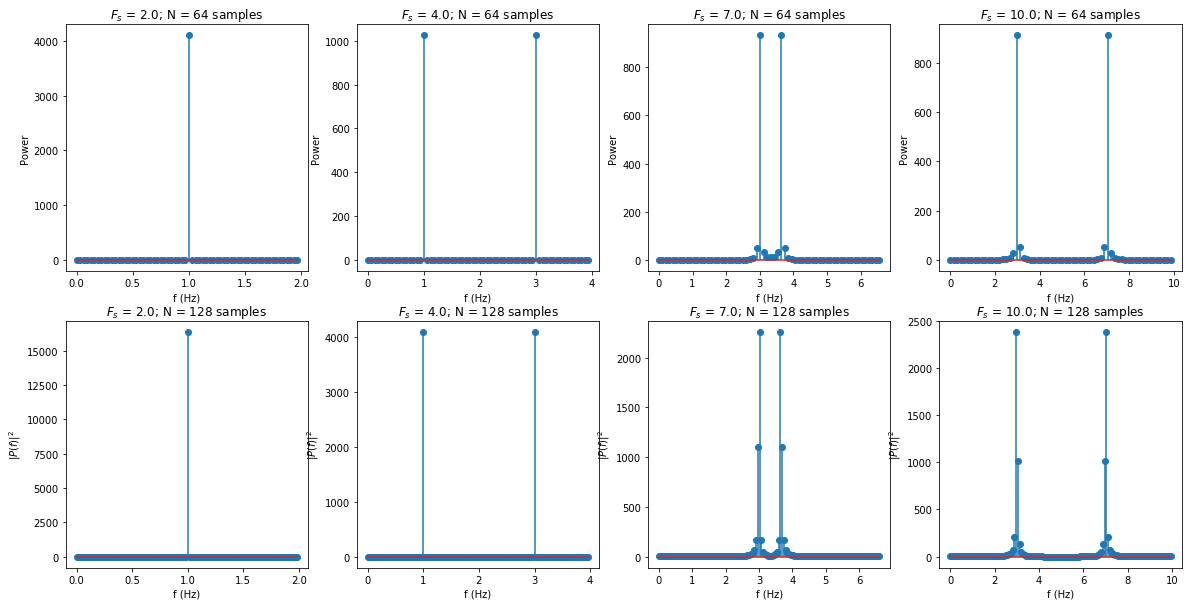

In [31]:
### Plotting everything together

plt.subplots(2, 4, sharex=True, sharey=True, figsize = (20, 10))
plt.title('Effect of Variation of Sampling Frequency and Time Duration on Spectrum')

for i in range(size):
    plt.subplot(2, size, i+1)
    plt.stem(frequencies_short[i, :], np.square(np.abs(ffts_short[i, :])), use_line_collection=True)
    plt.xlabel('f (Hz)')
    plt.ylabel('Power')
    plt.title('$F_s$ = ' + str(np.round(sampling_freq[i])) + '; ' + 'N = 64 samples')
    

for i, j in zip(range(size), range(size + 1, 2 * size + 1)):
    plt.subplot(2, size, j)
    plt.stem(frequencies_long[i, :], np.square(np.abs(ffts_long[i, :])), use_line_collection=True)
    plt.xlabel('f (Hz)')
    plt.ylabel('$|P(f)|^2$')
    plt.title('$F_s$ = ' + str(np.round(sampling_freq[i])) + '; ' + 'N = 128 samples')
    
plt.show()

---

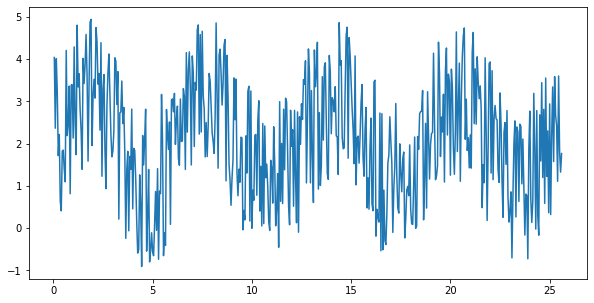

In [8]:
### Getting data and defining signal parameters

time, data = np.genfromtxt('data-cor.txt', dtype='float', unpack=True)
plt.figure(figsize=(10, 5))
plt.plot(time, data)
plt.show()

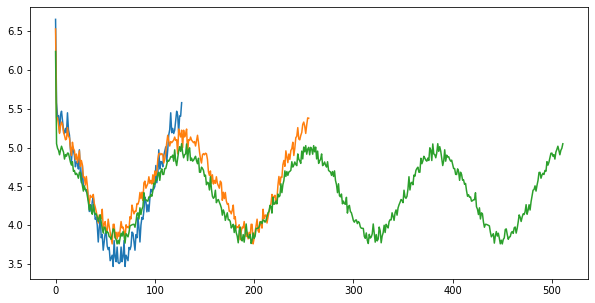

In [9]:
### Getting the autocorrelation of the data using AutoCorr()

indx1 = round(6.4 / 0.05)
indx2 = round(12.8 / 0.05)

acorr_5 = circ_autocorr(data[0:indx1])
acorr_10 = circ_autocorr(data[0:indx2])
acorr_full = circ_autocorr(data)

plt.figure(figsize=(10, 5))
plt.plot(acorr_5)
plt.plot(acorr_10)
plt.plot(acorr_full)
plt.show()

In [10]:
### Getting the autocorrelation using FFT and IFFT

acorr_5_fft = (1 / 128) * np.round(ifft(np.conj(fft(data[0:indx1])) * fft(data[0:indx1])))
acorr_10_fft = (1 / 256) * np.round(ifft(np.conj(fft(data[0:indx2])) * fft(data[0:indx2])))
acorr_full_fft = (1 / 512) * np.round(ifft(np.conj(fft(data)) * fft(data)))

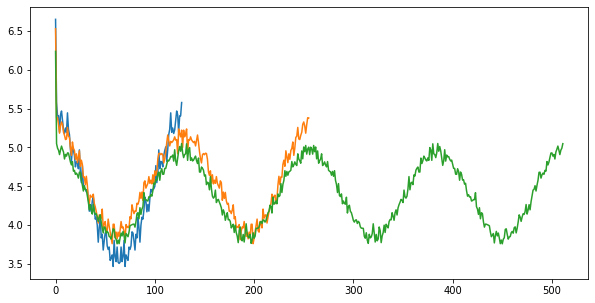

In [11]:
### Plotting 

plt.figure(figsize=(10, 5))
plt.plot(np.real(acorr_5_fft))
plt.plot(np.real(acorr_10_fft))
plt.plot(np.real(acorr_full_fft))
plt.show()